# Preparing the environment


## Libraries

In [1]:
#%pip install --upgrade pip
#%pip install pandas
#%pip install scipy 
#%pip install scikit-learn
#%pip install tqdm 
#%pip install plotly 
#%pip install matplotlib
#%pip install nbformat
#%pip install fastparquet
#%pip install pyarrow
#%pip install tqdm

In [2]:
# requirements
import pandas as pd
from utils.data_treatment import DataManager
from utils.eda import EDA

In [3]:
dm = DataManager()

# Dataset - CICDDoS2019

#### Description

The CICDDoS2019, available at [University of New Brunswick website](https://www.unb.ca/cic/datasets/ddos-2019.html), contains different kinds of DDoS attacks and realistic traffic profiles. It is a HTTP request report containing IP source address, destinatination ip addres, request time frame and the attack label.


### 1 - Load dataset

Analysing csv columns to convert it in HTTP equivalent data.

In [4]:
files = [f'DrDos_UDP', f'UDP']
dataset_path = "../0-datasets/CICDDoS2019"

df_cic = dm.load_data(files, dataset_path)
df_cic.shape

Found datasets:
../datasets/CICDDoS2019\DrDoS_UDP.csv
../datasets/CICDDoS2019\UDP.csv


(6919008, 88)

In [5]:
df_cic.head(2)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,101418,172.16.0.5-192.168.50.1-43443-6652-17,172.16.0.5,43443,192.168.50.1,6652,17,2018-12-01 12:36:57.628026,218395,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
1,21564,172.16.0.5-192.168.50.1-54741-9712-17,172.16.0.5,54741,192.168.50.1,9712,17,2018-12-01 12:36:57.628076,108219,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [6]:
df_cic[' Label'].unique()

<StringArray>
['DrDoS_UDP', 'BENIGN', 'MSSQL', 'UDP']
Length: 4, dtype: str

In [7]:
df_cic[' Label'].value_counts()

 Label
UDP          3754680
DrDoS_UDP    3134645
MSSQL          24392
BENIGN          5291
Name: count, dtype: int64

In [8]:
len(df_cic.columns)

88

In [9]:
df_cic.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

### 2 - Selecting Features

The dataset contains 88 columns, only 5 of them were selected by this study: ' Timestamp', Source IP, ' Destination IP', ' Destination Port', and ' Label'. They correspond respectively to timestamp, source IP, destination IP, destination port, and the attack specification (i.e.: 'DrDoS_UDP', 'BENIGN', 'MSSQL', 'UDP').


In [10]:
df_cic.dtypes

Unnamed: 0           int64
Flow ID                str
 Source IP             str
 Source Port         int64
 Destination IP        str
                    ...   
 Idle Max          float64
 Idle Min          float64
SimillarHTTP           str
 Inbound             int64
 Label                 str
Length: 88, dtype: object

#### Checking duplicates and missing values

In [11]:
df_cic.isna().sum()

Unnamed: 0         0
Flow ID            0
 Source IP         0
 Source Port       0
 Destination IP    0
                  ..
 Idle Max          0
 Idle Min          0
SimillarHTTP       0
 Inbound           0
 Label             0
Length: 88, dtype: int64

In [12]:
df_cic.duplicated().sum()

np.int64(0)

#### Final selection

In [13]:
df_selected_features = df_cic[[' Source IP', ' Destination IP', ' Destination Port', ' Timestamp', ' Label']].copy()

### 3 - Data Wrangling

#### Formating columns

Checking timestamp column format, it was noticed that it needs to be normalized to remove the nanoseconds.

In [14]:
df_selected_features[' Timestamp'].head()

0    2018-12-01 12:36:57.628026
1    2018-12-01 12:36:57.628076
2    2018-12-01 12:36:57.628164
3    2018-12-01 12:36:57.628166
4    2018-12-01 12:36:57.628217
Name:  Timestamp, dtype: str

Also, given the lack of HTTP information, an adaption of destination IP and port should be done to achieve an endpoint. Besides that, a column indicating a boolean value for the presence or absence of an anomaly would be easier to manipulate.

Considering all this, the steps below format the selected columns to more suitable format.

In [19]:
def prepare_columns(df):
	"""Converting columns to represent HTTP endpoints"""
	df[' Destination IP'] = df[' Destination IP'].astype(str)
	df[' Destination Port'] = df[' Destination Port'].astype(str)
	df['endpoint'] = df[' Destination IP'] + ':' + df[' Destination Port']
	df['is_anomaly'] = df[' Label'].map(lambda x: x != 'BENIGN')
	df = df[[ ' Source IP', 'endpoint', ' Timestamp', ' Label', 'is_anomaly']] # original names
	df.columns = ['address', 'endpoint', 'time_local', 'label', 'is_anomaly'] # converted names

	# parse timestamp
	df['time_local'] = pd.to_datetime(df['time_local'], errors='coerce')
	df = df.sort_values('time_local')
	df = df.dropna(subset=['time_local'])

	# create normalized columns
	df['time_local'] = df['time_local'].dt.floor('s')
	df['endpoint'] = df['endpoint'].astype(str)
	df['address'] = df['address'].astype(str)
	df['label'] = df['label'].astype(str)
	df['is_anomaly'] = df['is_anomaly'].astype(int)

	return df

In [21]:
df_formatted = prepare_columns(df_cic)
df_formatted

,address,endpoint,time_local,label,is_anomaly
3136802,172.16.0.5,192.168.50.4:15931,2018-11-03 10:42:57,MSSQL,1
3136803,172.16.0.5,192.168.50.4:29997,2018-11-03 10:42:57,MSSQL,1
3136804,172.16.0.5,192.168.50.4:29887,2018-11-03 10:42:57,MSSQL,1
3136805,172.16.0.5,192.168.50.4:7393,2018-11-03 10:42:57,MSSQL,1
3136806,172.16.0.5,192.168.50.4:57957,2018-11-03 10:42:57,MSSQL,1
...,...,...,...,...,...
3136797,172.16.0.5,192.168.50.1:6479,2018-12-01 13:04:45,DrDoS_UDP,1
3136798,172.16.0.5,192.168.50.1:33462,2018-12-01 13:04:45,DrDoS_UDP,1
3136799,172.16.0.5,192.168.50.1:22593,2018-12-01 13:04:45,DrDoS_UDP,1
3136800,172.16.0.5,192.168.50.1:46618,2018-12-01 13:04:45,DrDoS_UDP,1


#### Filter endpoint events

Below it was checked the endpoints request rate. As can be seen, there is a lot of endpoints with low number of requests, so a threshold is necessary to filter them. The chosen threshold was a minimum of 150 request, this reduces the total of endpoints and select those with reasonable quantity to perform the analysis.

In [22]:
counts = df_formatted['endpoint'].value_counts()
counts

endpoint
4.2.2.4:53           1171
192.168.50.1:137      361
192.168.50.1:80       336
8.8.8.8:53            291
74.208.236.171:80     247
                     ... 
172.16.0.5:52094        1
172.16.0.5:52262        1
172.16.0.5:16947        1
172.16.0.5:7827         1
172.16.0.5:30136        1
Name: count, Length: 134011, dtype: int64

In [23]:
consistent_endpoints = counts[counts >= 150].index
len(consistent_endpoints)

75

In [24]:
df_consist_endpoints = df_formatted[df_formatted['endpoint'].isin(consistent_endpoints)]

### 4 - Exploratory data analysis (EDA)


#### Check request frequency

In [25]:
df_continuity = df_consist_endpoints.copy()

It can be noticed when plotting the request evolution by time that, globally, the attacks are not widespread in the interval. So it is necessary to check each endpoint request rate, to evaluate its consistency for the analysis.


In [26]:
eda = EDA(df_continuity, label_col='label')

eda.plot_global_request_rate('s')

As can be seen by the plot below, some endpoints do not have both types of traffic (i.e.: anomalous, normal), so it is necessary to discard endpoint that do not have at least some attack interval. Normality is not a requirement, since we can assume that no request is the normal traffic behavior.

In [27]:
eda.df['endpoint'].value_counts().head(6).index

Index(['4.2.2.4:53', '192.168.50.1:137', '192.168.50.1:80', '8.8.8.8:53',
       '74.208.236.171:80', '172.105.219.195:443'],
      dtype='str', name='endpoint')

plot_start: 2018-11-03 10:49:00


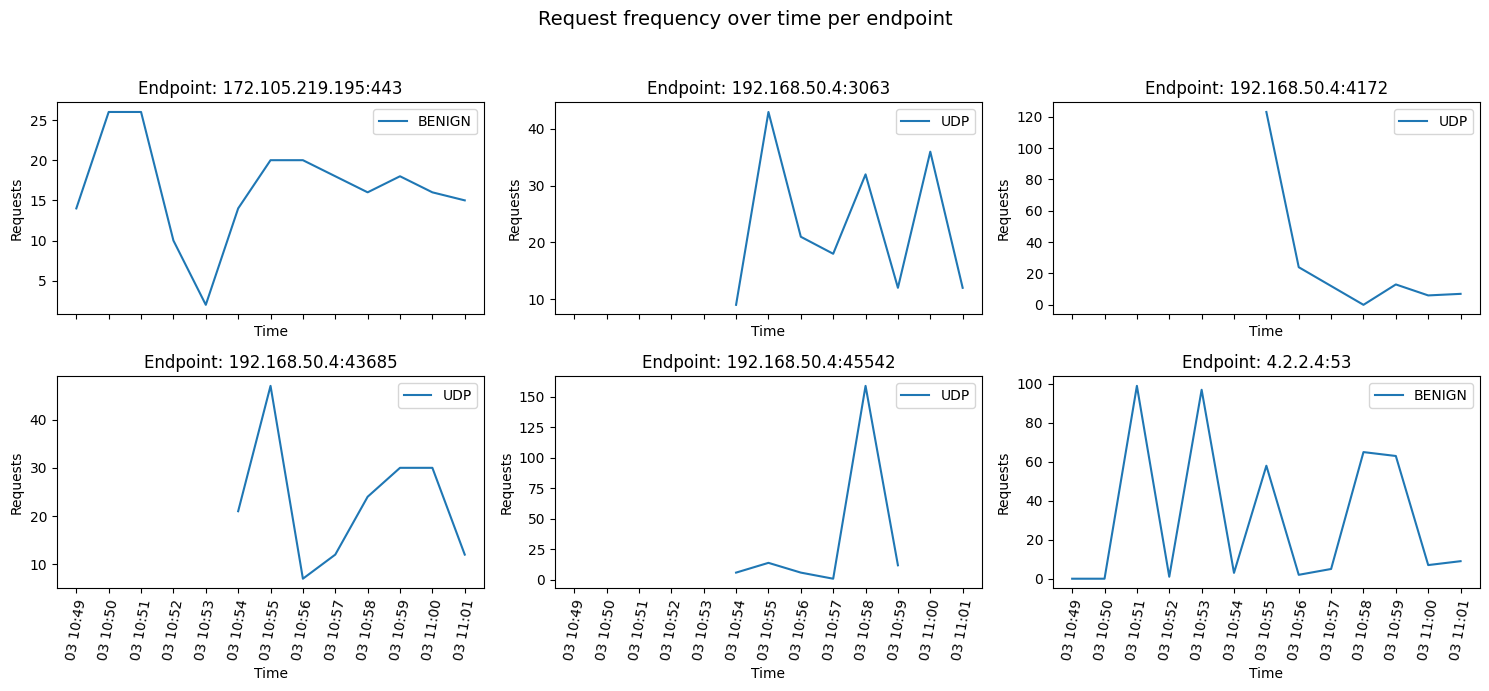

In [28]:
eda.plot_endpoint_request_rate(interval=1)

Checking if there are endpoints with no attacks:

In [ ]:
df_continuity[df_continuity['label'].isin(['BENIGN'])]['endpoint'].unique()

Grouping requests by endpoint and is_anomaly, the count of endpoints with no anomaly (0) or with anomaly (1) are tabulated. That way is possible visualize endpoints that do not have any attack (NaN or 0) or few attacks.

In [29]:
g_endpoint_anom = df_continuity.groupby(['endpoint','is_anomaly']).size().unstack(level='is_anomaly')
g_endpoint_anom

is_anomaly,0,1
endpoint,,
172.105.219.195:443,215.0,NaN
172.16.0.5:137,NaN,183.0
192.168.50.1:12687,NaN,151.0
192.168.50.1:137,NaN,361.0
192.168.50.1:15705,NaN,182.0
...,...,...
192.168.50.4:8703,NaN,154.0
192.168.50.4:9875,NaN,151.0
4.2.2.4:53,1171.0,NaN


As could be noticed, no endpoint had both normal and anomaly traffic. To overcome this, endpoint was modified to consider only the IP.

In [33]:
has_clean_n_dirty_traffic = (g_endpoint_anom[1] >= 1)
g_endpoint_anom[has_clean_n_dirty_traffic]

is_anomaly,0,1
endpoint,,
172.16.0.5:137,NaN,183.0
192.168.50.1:12687,NaN,151.0
192.168.50.1:137,NaN,361.0
192.168.50.1:15705,NaN,182.0
192.168.50.1:16460,NaN,151.0
...,...,...
192.168.50.4:7107,NaN,158.0
192.168.50.4:7486,NaN,161.0
192.168.50.4:8552,NaN,150.0


In [35]:
def prepare_columns2(df):
	"""Converting columns to represent HTTP endpoints"""
	df[' Destination IP'] = df[' Destination IP'].astype(str)
	df['endpoint'] = df[' Destination IP']
	df['is_anomaly'] = df[' Label'].map(lambda x: x != 'BENIGN')
	df = df[[ ' Source IP', 'endpoint', ' Timestamp', ' Label', 'is_anomaly']] # original names
	df.columns = ['address', 'endpoint', 'time_local', 'label', 'is_anomaly'] # converted names

	# parse timestamp
	df['time_local'] = pd.to_datetime(df['time_local'], errors='coerce')
	df = df.sort_values('time_local')
	df = df.dropna(subset=['time_local'])

	# create normalized columns
	df['time_local'] = df['time_local'].dt.floor('s')
	df['endpoint'] = df['endpoint'].astype(str)
	df['address'] = df['address'].astype(str)
	df['label'] = df['label'].astype(str)
	df['is_anomaly'] = df['is_anomaly'].astype(int)

	return df

In [36]:
df_formatted = prepare_columns2(df_cic)

In [37]:
counts = df_formatted['endpoint'].value_counts()
counts

endpoint
192.168.50.4      3777978
192.168.50.1      3132763
172.16.0.5           2980
4.2.2.4              1171
192.168.50.9          355
                   ...   
34.223.240.82           1
172.217.10.102          1
34.214.202.211          1
104.18.58.178           1
192.168.50.254          1
Name: count, Length: 238, dtype: int64

In [38]:
consistent_endpoints = counts[counts >= 150].index
len(consistent_endpoints)

10

In [39]:
df_consist_endpoints = df_formatted[df_formatted['endpoint'].isin(consistent_endpoints)]

In [41]:
eda = EDA(df_consist_endpoints.copy(), label_col='label')

g_endpoint_anom = eda.df.groupby(['endpoint','is_anomaly']).size().unstack(level='is_anomaly')
g_endpoint_anom

is_anomaly,0,1
endpoint,,
172.105.219.195,215.0,NaN
172.16.0.5,NaN,2980.0
192.168.50.1,4.0,3132759.0
192.168.50.4,NaN,3777978.0
192.168.50.6,235.0,NaN
192.168.50.8,251.0,NaN
192.168.50.9,355.0,NaN
4.2.2.4,1171.0,NaN
74.208.236.171,247.0,NaN


The analysis results show that it is not possible to find a reasonable aggregation that represents endpoint level analysis in CICDDoS dataset. In IP or IP:port aggregation normal traffic and attack traffic are disjoint events, they do not occur for the same endpoint.